# Polar coordinate input causes bias in predicted first position

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from spatialnet import trajectory
from spatialnet.fileio import load_run
from spatialnet.parameters import print_params

In [2]:
# Directory where model is loaded from
RUN_DIRPATH = 'models/20220523_test'

# Length of trajectories
N_STEPS = 50

# Number of trajectories to sample
N_TRIALS = 500

## Load model and run parameters

In [3]:
run_params, model = load_run(RUN_DIRPATH)

print_params(run_params)

model:
  n_units: 100
  output_bias: false
  rnn_bias: true
num_batches: 10
num_epochs: 3
test_batch_size: 500
trainer:
  batch_size: 500
  lambda_h: 0.1
  lambda_w: 0.5
  learning_rate: 0.0001
trajectory:
  boundary_height: 2.0
  boundary_shape: square
  coordinates: cartesian
  mean_speed: 0.2
  n_steps: 450
  rng_seed: 999
  std_norm: 0.5
  time_step: 0.1



## Simulate trajectories

In [4]:
# Use trajectory generator with same coordinate system as run
traj_params = dict(run_params['trajectory'], n_steps=N_STEPS)

# Sample batch
tgen = trajectory.TrajectoryGenerator(**traj_params)
vel, pos = tgen.smp_batch(N_TRIALS)

## Run model on all trials

In [5]:
pos_est, u_vals = model.run_np(vel)

## Plot results

In [6]:
b_shape = run_params['trajectory']['boundary_shape']
b_height = run_params['trajectory']['boundary_height']
boundary = trajectory.get_boundary(b_shape, b_height)

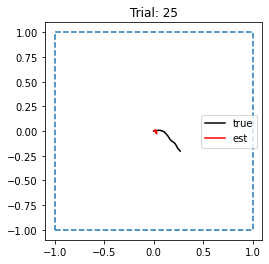

In [7]:
trial_plt = 25
t_start = 0
t_stop = 20

pos_plt = pos[trial_plt][t_start:t_stop]
pos_est_plt = pos_est[trial_plt][t_start:t_stop]

fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')
ax.set_title(f'Trial: {trial_plt}')
trajectory.plot_position_estimate(boundary, pos_plt, pos_est_plt, ax)

## Check for bias in initial position

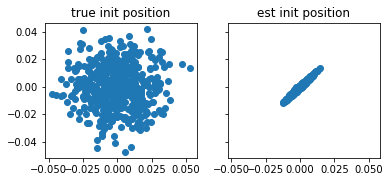

In [8]:
# True initial positions
x0 = pos[:, 0, 0]
y0 = pos[:, 0, 1]

# Estimated initial positions
x0_est = pos_est[:, 0, 0]
y0_est = pos_est[:, 0, 1]

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

ax[0].scatter(x0, y0)
ax[0].set_title('true init position')
ax[0].set_aspect(1.0)

ax[1].scatter(x0_est, y0_est)
ax[1].set_title('est init position')
ax[1].set_aspect(1.0)

Text(0, 0.5, 'mse')

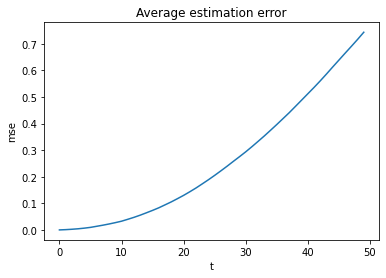

In [9]:
sq_err = np.sum((pos_est - pos) ** 2, axis=2)
mse = np.mean(sq_err, axis=0)
plt.plot(mse)
plt.title('Average estimation error')
plt.xlabel('t')
plt.ylabel('mse')

Text(0, 0.5, 'mse')

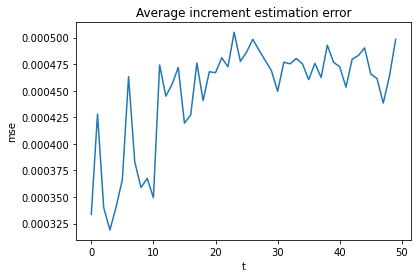

In [10]:
dpos = np.diff(pos, axis=1, prepend=0)
dpos_est = np.diff(pos_est, axis=1, prepend=0)

sq_err = np.sum((dpos_est - dpos) ** 2, axis=2)
mse = np.mean(sq_err, axis=0)
plt.plot(mse)
plt.title('Average increment estimation error')
plt.xlabel('t')
plt.ylabel('mse')